# Explore here

In [32]:
# Your code here
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import *
from imblearn.metrics import specificity_score
import statsmodels.api as sm
import numpy as np
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

In [33]:
df = pd.read_csv('/workspaces/pille9-decision-tree/data/raw/diabetes.csv')
pd.set_option('display.max_columns', None)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [34]:
df.shape

(768, 9)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [36]:
# Analizar constantes
n_unicos = df.nunique()
n_unicos

Pregnancies                  17
Glucose                     136
BloodPressure                47
SkinThickness                51
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
Age                          52
Outcome                       2
dtype: int64

In [37]:
# Revisar duplicados
df.duplicated().sum()

np.int64(0)

In [38]:
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [39]:
# Separar variable dependiente de independientes
X = df.drop(['Outcome'], axis = 1)
y = df['Outcome']

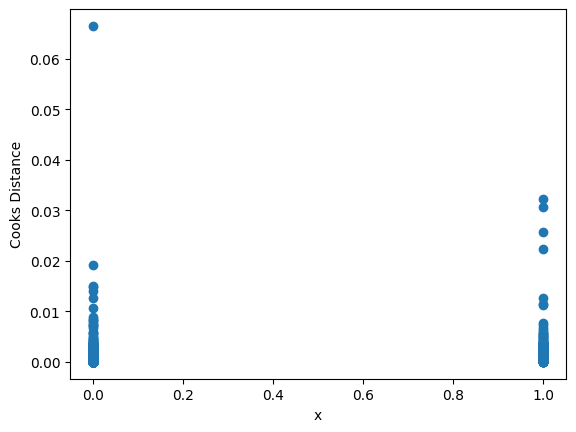

In [40]:
# Ajustar modelo de regresión lineal
X = sm.add_constant(X)
model = sm.OLS(y,X).fit()

# Distancia de cook
cooks_distance = model.get_influence().cooks_distance

plt.scatter(df.Outcome, cooks_distance[0])
plt.xlabel('x')
plt.ylabel('Cooks Distance')
plt.show()

In [41]:
# Punto de corte para la distancia de cook
pto_corte = 4/len(df)

# Anuncios por encima del pto de corte
len(np.where(cooks_distance[0]>pto_corte)[0])

# Eliminar observaciones que se consideran influentes
df_1 = df.drop(np.where(cooks_distance[0] > pto_corte)[0])

In [42]:
# Separamos las variables independientes de la dependiente
X = df_1.drop(['Outcome'], axis=1)
y = df_1['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# Usamos xgb para conocer la importancia de las características
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42).fit(X_train, y_train)
df_imp = pd.DataFrame({'Feature':X_train.columns, 'Importance':xgb_model.feature_importances_*100})
df_imp = df_imp.sort_values(by='Importance', ascending=False)
df_imp

,Feature,Importance
1,Glucose,30.302036
5,BMI,14.895809
7,Age,12.740658
6,DiabetesPedigreeFunction,10.019794
4,Insulin,9.256279
2,BloodPressure,8.854501
3,SkinThickness,8.391212
0,Pregnancies,5.539701


In [44]:
## VIF
X_train.corr()

vif = pd.Series([variance_inflation_factor(X_train.corr().values, i) for i in range(X_train.corr().shape[1])], index=X_train.columns)
vif

Pregnancies                 4.623206
Glucose                     3.082400
BloodPressure               1.938725
SkinThickness               5.024259
Insulin                     3.936809
BMI                         3.217195
DiabetesPedigreeFunction    1.308176
Age                         6.110227
dtype: float64

<Axes: >

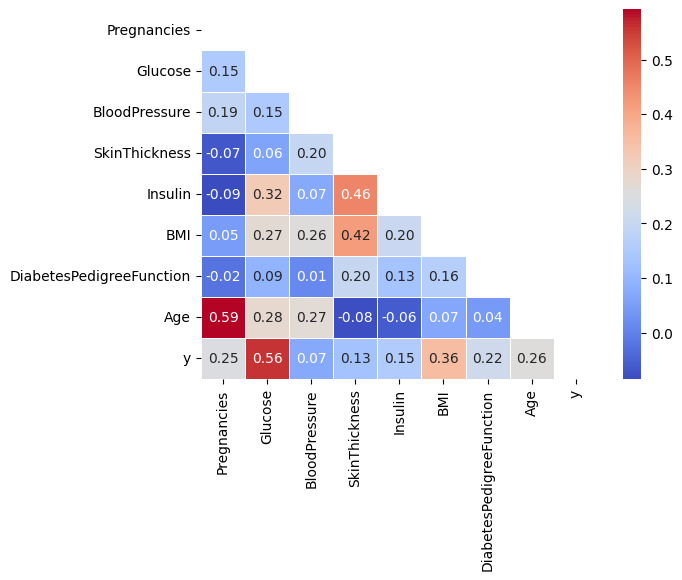

In [45]:
X_corr = X_train.copy()
X_corr['y'] = y_train
corr = X_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')

In [46]:
X_train["Outcome"] = y_train.values
X_test["Outcome"] = y_test.values
X_train.to_csv("../data/processed/train_data.csv", index = False)
X_test.to_csv("../data/processed/test_data.csv", index = False)

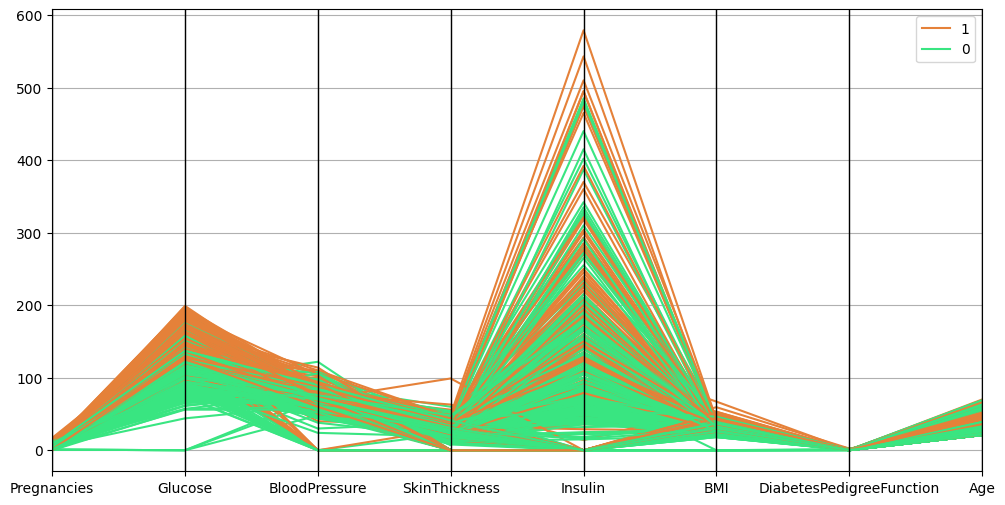

In [47]:
plt.figure(figsize=(12, 6))

pd.plotting.parallel_coordinates(df_1, "Outcome", color = ("#E58139", "#39E581", "#8139E5"))

plt.show()

In [48]:
y_train = X_train["Outcome"]
X_train = X_train.drop(["Outcome"], axis = 1)
y_test = X_test["Outcome"]
X_test = X_test.drop(["Outcome"], axis = 1)

In [49]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state = 42)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

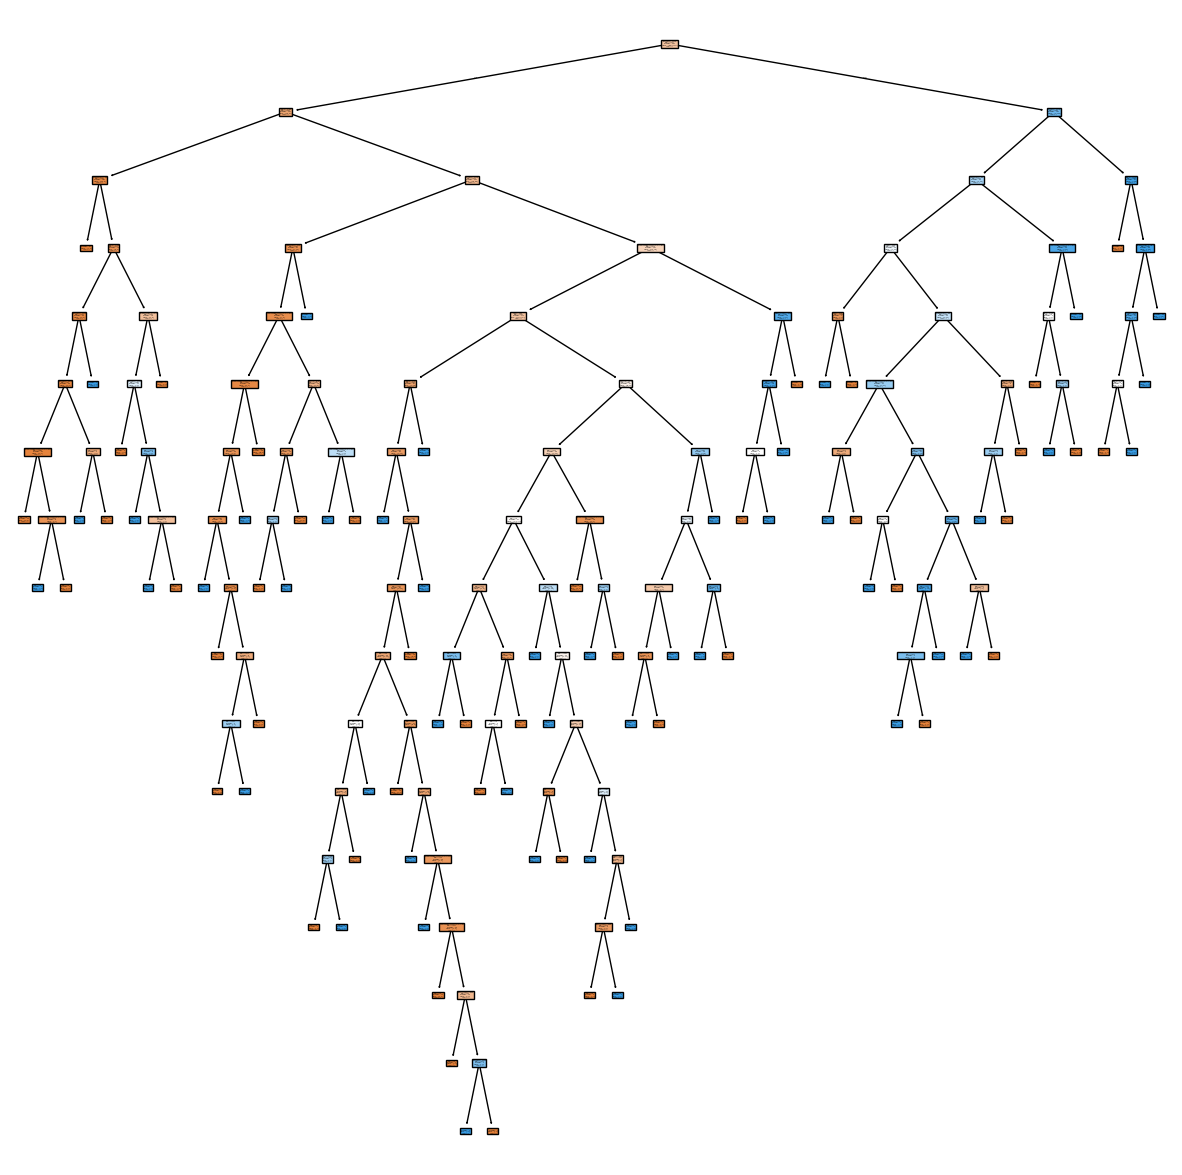

In [50]:
from sklearn import tree

fig = plt.figure(figsize=(15,15))

tree.plot_tree(model, feature_names = list(X_train.columns), class_names = ["0", "1"], filled = True)

plt.show()

In [51]:
y_pred_test = model.predict(X_test)
y_pred_test

array([0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [52]:
y_pred_train = model.predict(X_train)

In [53]:
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df

In [54]:
get_metrics(y_train, y_test, y_pred_train, y_pred_test)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,1.000000,1.000000,1.000000,1.00,1.000000,1.000000
Test,0.680272,0.552381,0.649506,0.58,0.527273,0.771739
Diferencia,0.319728,0.447619,0.350494,0.42,0.472727,0.228261


In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

hyperparams = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 3, 5, 15, 20],
    "min_samples_split": [2, 5, 10, 15],
    "min_samples_leaf": [1, 2, 4, 6]
}

grid = GridSearchCV(model, hyperparams, scoring = "accuracy", cv = 10)
grid

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 3, 5, 15, 20],
                         'min_samples_leaf': [1, 2, 4, 6],
                         'min_samples_split': [2, 5, 10, 15]},
             scoring='accuracy')

In [56]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

grid.fit(X_train, y_train)

print(f"Best hyperparameters: {grid.best_params_}")

Best hyperparameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [63]:
model = DecisionTreeClassifier(criterion = "gini", max_depth = 3, min_samples_leaf = 2, min_samples_split = 2, random_state = 42)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=2, random_state=42)

In [64]:
y_pred_test = model.predict(X_test)
y_pred_test

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [65]:
y_pred_train = model.predict(X_train)

In [66]:
get_metrics(y_train, y_test, y_pred_train, y_pred_test)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.789744,0.616822,0.719053,0.798387,0.502538,0.935567
Test,0.707483,0.516854,0.649308,0.676471,0.418182,0.880435
Diferencia,0.082261,0.099968,0.069744,0.121917,0.084356,0.055132


In [68]:
from pickle import dump

dump(model, open("../models/tree_classifier_crit-gini_maxdepth-3_minleaf-2_minsplit2_42.sav", "wb"))